MLP from Scratch on Wine Quality Dataset

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [11]:
def load_wine_dataset(csv_path, wine_type_label):
    """ 
    Loads a wine dataset and appends a binary wine-type indicator.
    wine type label:
        0 -> red wine
        1 -> white wine
    """
    df = pd.read_csv(csv_path, sep=';')

    X_features = df.drop('quality', axis=1).values

    # Regression target (wine quality score)
    y = df['quality'].values.reshape(-1, 1)

    # Domain indicator feature
    domain_indicator = np.full((X_features.shape[0], 1), wine_type_label)

    # Append indicator as an extra feature
    X = np.hstack([X_features, domain_indicator])

    return X, y, domain_indicator

In [32]:
def initialize_parameters(layer_dimensions):

    weights = {}
    biases = {}

    for layer in range(1, len(layer_dimensions)):
        fan_in = layer_dimensions[layer - 1]
        fan_out = layer_dimensions[layer]

        # Normal He initialization for ReLU
        weights[layer] = np.random.randn(fan_in, fan_out) * np.sqrt(2 / fan_in)
        biases[layer] = np.zeros((1, fan_out))

    return weights, biases

In [33]:
def relu(z):
    return np.maximum(0, z)


def relu_derivative(z):
    # Derivative of ReLU
    return (z > 0).astype(float)

In [36]:
def forward_propagation(X, weights, biases):
    """
    Performs forward propagation through the network.
    Returns:
        activations (A)
        pre-activations (Z)
    """
    activations = {0: X}
    pre_activations = {}

    num_layers = len(weights)

    # Hidden layers
    for layer in range(1, num_layers):
        Z = activations[layer - 1] @ weights[layer] + biases[layer]
        A = relu(Z)

        pre_activations[layer] = Z
        activations[layer] = A

    # Output layer (linear activation for regression)
    Z_out = activations[num_layers - 1] @ weights[num_layers] + biases[num_layers]
    pre_activations[num_layers] = Z_out
    activations[num_layers] = Z_out

    return activations, pre_activations

In [39]:
def backward_propagation(y_true, activations, pre_activations, weights, biases, learning_rate):
    
    # Manual backpropagation using Mean Squared Error loss. Updating weights and biases
    
    num_samples = y_true.shape[0]
    num_layers = len(weights)

    # Gradient of MSE loss w.r.t. output
    dA = (activations[num_layers] - y_true) / num_samples

    for layer in reversed(range(1, num_layers + 1)):
        A_prev = activations[layer - 1]

        # Gradients for weights and biases
        dW = A_prev.T @ dA
        dB = np.sum(dA, axis=0, keepdims=True)

        # Propagate gradient backward if not input layer
        if layer > 1:
            dA = (dA @ weights[layer].T) * relu_derivative(pre_activations[layer - 1])

        # Gradient descent update
        weights[layer] -= learning_rate * dW
        biases[layer] -= learning_rate * dB

In [43]:
# Training Loop
def train_model(X, y, layer_dimensions, learning_rate=0.01, epochs=300):

# Trains the MLP using batch gradient descent.

    weights, biases = initialize_parameters(layer_dimensions)
    losses = []

    for epoch in range(epochs):
        activations, pre_activations = forward_propagation(X, weights, biases)
        predictions = activations[len(layer_dimensions) - 1]

        loss = mean_squared_error(y, predictions)
        losses.append(loss)

        backward_propagation(y, activations, pre_activations, weights, biases, learning_rate)

    return weights, biases, losses

Overall Test MSE: 0.6525916949714857
Red Wine Test MSE: 0.6527790003037227
White Wine Test MSE: 0.652525093179731


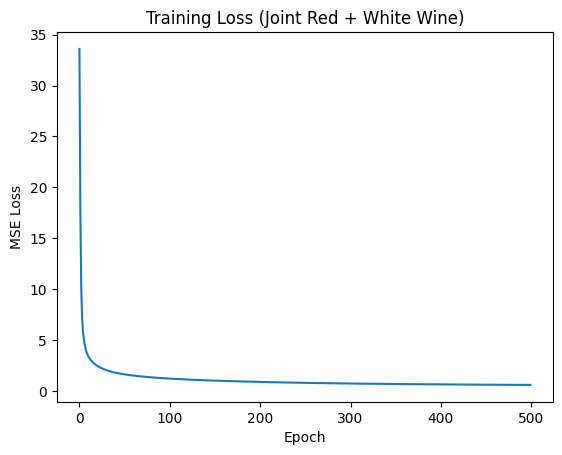

In [48]:
#Execution
if __name__ == "__main__":

    # Load datasets
    X_red, y_red, domain_red = load_wine_dataset("/home/naman/Cryptonite-RTP-NamanGoel/Task-3/wine+quality/winequality_red.csv", 0)
    X_white, y_white, domain_white = load_wine_dataset("/home/naman/Cryptonite-RTP-NamanGoel/Task-3/wine+quality/winequality_white.csv", 1)

    # Combine datasets
    X_all = np.vstack([X_red, X_white])
    y_all = np.vstack([y_red, y_white])
    domain_all = np.vstack([domain_red, domain_white]).flatten() #flattening required for numpy boolean masking

    X_train, X_test, y_train, y_test, domain_train, domain_test = train_test_split(
        X_all, y_all, domain_all,
        test_size=0.2,
        random_state=42
    )

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model configuration
    layer_dimensions = [
        X_train_scaled.shape[1],  # input features (11 + domain indicator)
        64,
        32,
        1
    ]

    # Training
    weights, biases, training_losses = train_model(
        X_train_scaled,
        y_train,
        layer_dimensions,
        learning_rate=0.015,
        epochs=500
    )

    # Evaluation
    test_activations, _ = forward_propagation(X_test_scaled, weights, biases) # _ is unused pre-activations during testing
    test_predictions = test_activations[len(layer_dimensions) - 1]

    overall_mse = mean_squared_error(y_test, test_predictions)

    red_mask = domain_test == 0 # Numpy boolean masking, it creates a boolean array marking red wine samples.
    white_mask = domain_test == 1

    red_mse = mean_squared_error(y_test[red_mask], test_predictions[red_mask]) #y_test[red_mask] gives only those y_test values where red_mask is True
    white_mse = mean_squared_error(y_test[white_mask], test_predictions[white_mask])

    print("Overall Test MSE:", overall_mse)
    print("Red Wine Test MSE:", red_mse)
    print("White Wine Test MSE:", white_mse)

    plt.plot(training_losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Loss (Joint Red + White Wine)")
    plt.show()

At epoch = 300,  lr = 0.01  
Overall Test MSE: 1.1511034827294098  
Red Wine Test MSE: 0.9090770482708551  
White Wine Test MSE: 1.2371629343981974

At epoch = 600,  lr = 0.01  
Overall Test MSE: 0.8112069639574319  
Red Wine Test MSE: 0.594360826978225  
White Wine Test MSE: 0.8883128374818423

Methods  
ReLU and vanilla gradient descent were deliberately chosen to minimize hidden assumptions and maximize transparency in a from-scratch neural network implementation. Advanced activations and adaptive optimizers, while powerful, introduce additional theoretical constraints and algorithmic complexity that are better handled by deep learning frameworks rather than manual implementations.    
A deep multi-layer perceptron (MLP) was implemented entirely from scratch using NumPy to predict wine quality scores. Both red and white wine datasets from the UCI repository were combined into a single training set. A binary domain indicator was appended to each sample to explicitly encode wine type. The network employed ReLU activations in hidden layers, a linear output layer for regression, He weight initialization, and batch gradient descent optimization. Input features were standardized using statistics computed from the training set. The model was trained for 500 epochs with a learning rate of 0.015.  
  
Results  
The model achieved an overall test mean squared error (MSE) of 0.65 corresponds to an RMSE (MSE_root) of approximately 0.81, indicating that the model’s predictions deviate from the true wine quality scores by less than one quality point on average. Given the discrete and limited scale of the target variable, this represents reasonable predictive accuracy and demonstrates that the model captures meaningful relationships between physicochemical properties and perceived quality.  
The model achieves nearly identical performance on red wine (0.65) and white wine (0.65) subsets. The training loss decreased smoothly and monotonically, indicating stable optimization and good convergence. The close alignment of red and white wine test errors demonstrates that joint training with a domain indicator effectively mitigates domain bias and enables robust generalization across wine types.  